In [1]:
import asyncio
import numpy as np
import concurrent.futures
from scipy.integrate import simpson
from functools import partial

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

from tqdm.auto import tqdm as tqdm_pandas
tqdm_pandas.pandas(desc="Lightcurves Processed")
from tqdm.asyncio import tqdm as tqdm_asyncio

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=20)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
# plt.style.use('seaborn-v0_8-colorblind')

from astroquery.esa.xmm_newton import XMMNewton
from astroquery.esasky import ESASky
import astropy.units as u
from astropy.coordinates import SkyCoord

import warnings
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

### Collecting all objects

In [3]:
all_objects = pd.read_parquet(base_directory + 'original_features_by_name.parquet', columns=['name', 'type', 'ra', 'dec'])
all_objects = all_objects.query("type == 'QX'")
# all_objects = all_objects.sample(2000)
all_objects

,name,type,ra,dec
41,1WGA J0852.8+1346,QX,133.221919,13.768493
42,1WGA J0924.4+5215,QX,141.114203,52.252941
44,1WGA J1008.6+5437,QX,152.150767,54.625040
45,1WGA J1009.4+5334,QX,152.361450,53.573456
47,1WGA J1052.6+5724,QX,163.164999,57.408762
...,...,...,...,...
30201,XBS J104509.3-012442,QX,161.288773,-1.411676
30207,XLSS J022249.5-051452,QX,35.706979,-5.248087
30208,XMDS J02234-0454,QX,35.871965,-4.914419
30211,XMS J103020.7+305637,QX,157.585938,30.943794


### Query Epic Courses by Name and Coordinate with `astroquery.esa.xmmnewton`

In [4]:
# async def epic_data_length_async_semaphore(sempahore, name=None, ra=None, dec=None, radius=1.5 / 3600):
#     async with sempahore:
#         if name:
#             epic_source, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(target_name=name)
#         elif ra and dec:
#             coordinates = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
#             epic_source, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(coordinates=coordinates, radius=radius)
#         return len(epic_source)
    
# async def epic_data_length_async(name=None, ra=None, dec=None, radius=1.5 / 3600):
#     if name:
#         epic_source, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(target_name=name)
#     elif ra and dec:
#         coordinates = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
#         epic_source, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(coordinates=coordinates, radius=radius)
#     return len(epic_source)
    
def download_epic_metadata(name=None, ra=None, dec=None, radius=1.5 / 3600):
    try:
        if name:
            epic_source, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(target_name=name)
        elif ra and dec:
            coordinates = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
            epic_source, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(coordinates=coordinates, radius=radius)
    except Exception as e:
        return e
    # return epic_source, cat_4xmm, stack_4xmm
    return epic_source


In [5]:
# all_objects['xmm_name_resolved_epic_source'] = all_objects.parallel_apply(lambda row: download_epic_metadata(name=row['name']), axis=1)

In [6]:
# all_objects['xmm_coord_resolved_epic_source'] = all_objects.parallel_apply(lambda row: download_epic_metadata(ra=row['ra'], dec=row['dec']), axis=1)

In [8]:
# all_objects.to_pickle(base_directory + 'XMM/QXs_xmm_epic_source.pkl')
all_objects = pd.read_pickle(base_directory + 'XMM/QXs_xmm_epic_source.pkl')

all_objects

,name,type,ra,dec,xmm_name_resolved_epic_source,xmm_coord_resolved_epic_source
41,1WGA J0852.8+1346,QX,133.221919,13.768493,[],[]
42,1WGA J0924.4+5215,QX,141.114203,52.252941,"[[44.27828504862878, 52.173688090766106, 87.18...","[[44.25845292187852, 52.25307057448483, 393.47..."
44,1WGA J1008.6+5437,QX,152.150767,54.625040,[],[]
45,1WGA J1009.4+5334,QX,152.361450,53.573456,"[[50.24747127235173, 53.5567847182877, 10.4464...",[]
47,1WGA J1052.6+5724,QX,163.164999,57.408762,"[[53.22681934346944, 57.31852070570231, 17.283...","[[53.18857366167168, 57.40866142500829, 10821...."
...,...,...,...,...,...,...
30201,XBS J104509.3-012442,QX,161.288773,-1.411676,"[[48.34429877502301, -1.3953788169786736, 31.7...","[[48.31384109933196, -1.4117296554403476, 2276..."
30207,XLSS J022249.5-051452,QX,35.706979,-5.248087,"[[-59.16630466785926, -5.304918693782029, 1063...","[[-59.14087987618536, -5.248262145924891, 2167..."
30208,XMDS J02234-0454,QX,35.871965,-4.914419,Unable to find coordinates for name 'XMDS J022...,"[[-58.78321926695352, -4.91433386576112, 235.5..."
30211,XMS J103020.7+305637,QX,157.585938,30.943794,"[[59.12609183452983, 30.89496518939936, 140.77...","[[59.05304851619081, 30.943637885618557, 652.4..."


#### Statistics

In [ ]:
def print_num_xmmepic(df, object_type=None):
    df = df.query(f"type == '{object_type}'") if object_type else df
    type_string = object_type + ' ' if object_type else ''

    num_xmm_by_name = df.xmm_name_resolved_epic_source.apply(pd.api.types.is_number).sum()
    num_xmm_by_coordinates = df.xmm_coord_resolved_epic_source.apply(pd.api.types.is_number).sum()

    print(f'{num_xmm_by_name}/{df.shape[0]} ({num_xmm_by_name / df.shape[0]:.2%}) {type_string}objects were resolved by name by astroquery.esa.xmmnewton')
    print(f'{num_xmm_by_coordinates}/{df.shape[0]} ({num_xmm_by_coordinates / df.shape[0]:.2%}) {type_string}objects were resolved by coordionates by astroquery.esa.xmmnewton\n')

# print_num_xmmepic(all_objects, object_type=None)
# print_num_xmmepic(all_objects, object_type='Q')
# print_num_xmmepic(all_objects, object_type='QR')
print_num_xmmepic(all_objects, object_type='QX')

AttributeError: 'DataFrame' object has no attribute 'xmm_epic_data_length_by_name'

In [ ]:
def print_num_xmmepic(df, object_type=None):
    df = df.query(f"type == '{object_type}'") if object_type else df
    type_string = object_type + ' ' if object_type else ''

    df_name_resolved = df[df.xmm_epic_data_length_by_name.apply(pd.api.types.is_number)]
    df_coordinate_resolved = df[df.xmm_epic_data_length_by_coordinates.apply(pd.api.types.is_number)]

    num_xmm_by_name = (df_name_resolved.xmm_epic_data_length_by_name > 0).sum()
    num_xmm_by_coordinates = (df_coordinate_resolved.xmm_epic_data_length_by_coordinates > 0).sum()

    print(f'{num_xmm_by_name}/{df.shape[0]} ({num_xmm_by_name / df.shape[0]:.2%}) {type_string}objects yielded >= 1 rows by name by astroquery.esa.xmmnewton')
    print(f'{num_xmm_by_coordinates}/{df.shape[0]} ({num_xmm_by_coordinates / df.shape[0]:.2%}) {type_string}objects yielded >= 1 rows by coordinates by astroquery.esa.xmmnewton\n')

# print_num_xmmepic(all_objects, object_type=None)
# print_num_xmmepic(all_objects, object_type='Q')
# print_num_xmmepic(all_objects, object_type='QR')
print_num_xmmepic(all_objects, object_type='QX')

2629/32187 (8.17%) objects yielded >= 1 rows by name by astroquery.esa.xmmnewton
1121/32187 (3.48%) objects yielded >= 1 rows by coordinates by astroquery.esa.xmmnewton

768/19613 (3.92%) Q objects yielded >= 1 rows by name by astroquery.esa.xmmnewton
81/19613 (0.41%) Q objects yielded >= 1 rows by coordinates by astroquery.esa.xmmnewton

47/1283 (3.66%) QR objects yielded >= 1 rows by name by astroquery.esa.xmmnewton
5/1283 (0.39%) QR objects yielded >= 1 rows by coordinates by astroquery.esa.xmmnewton

870/2429 (35.82%) QX objects yielded >= 1 rows by name by astroquery.esa.xmmnewton
510/2429 (21.00%) QX objects yielded >= 1 rows by coordinates by astroquery.esa.xmmnewton



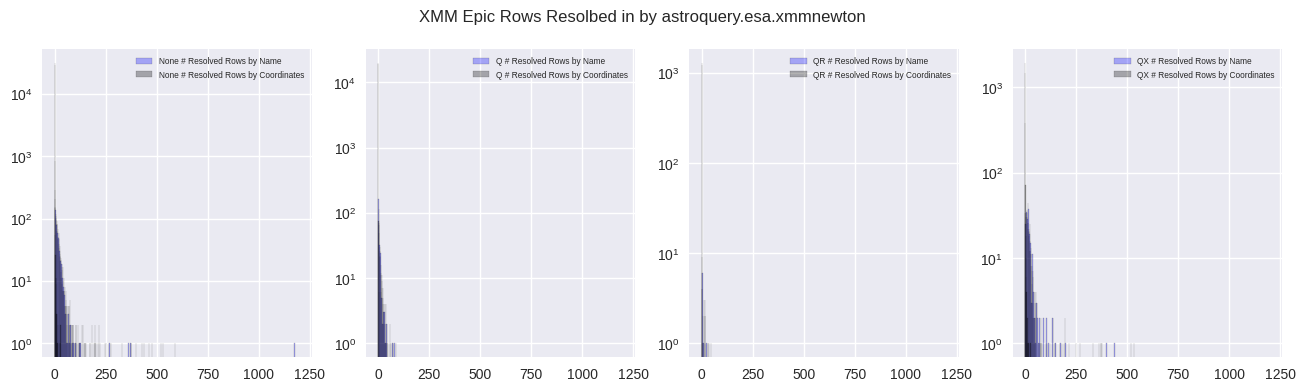

In [10]:
nrows, ncols = 1, 4
hist_bins = np.linspace(0, 1200, 1201).astype(int)
alpha = 0.3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

for ax, object_type in zip(axs, [None, 'Q', 'QR', 'QX']):
    df = all_objects.query(f"type == '{object_type}'") if object_type else all_objects
    df_name_resolved = df[df.xmm_epic_data_length_by_name.apply(pd.api.types.is_number)]
    df_coordinate_resolved = df[df.xmm_epic_data_length_by_coordinates.apply(pd.api.types.is_number)]

    ax.hist(df_name_resolved.xmm_epic_data_length_by_name, bins=hist_bins, label=f'{object_type} # Resolved Rows by Name', alpha=alpha, color='b', edgecolor='k', log=True)
    ax.hist(df_coordinate_resolved.xmm_epic_data_length_by_coordinates, bins=hist_bins, label=f'{object_type} # Resolved Rows by Coordinates', alpha=alpha, color='k', edgecolor='k', log=True)

    # ax.set_xticks(hist_bins + 0.5, labels=hist_bins)
    # ax.tick_params(axis='x', which='both', labelsize=8)
    ax.legend(fontsize=6)

fig.suptitle('XMM Epic Rows Resolbed in by astroquery.esa.xmmnewton')
plt.show()

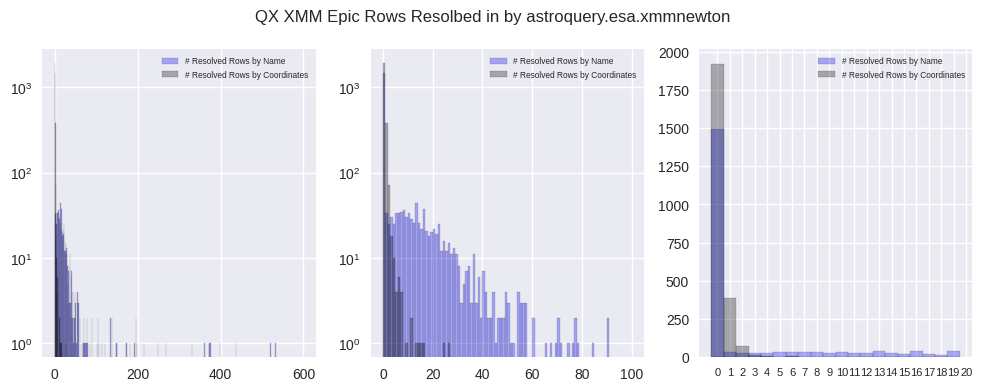

In [ ]:
nrows, ncols = 1, 3
alpha = 0.3
log_hists = [True, True, False]
hist_bin_list = [np.linspace(0, range_end, range_end + 1).astype(int) for range_end in [600, 100, 20]]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

for ax, log_hist, hist_bins in zip(axs, log_hists, hist_bin_list):
    df = all_objects.query("type == 'QX'") if object_type else all_objects
    df_name_resolved = df[df.xmm_epic_data_length_by_name.apply(pd.api.types.is_number)]
    df_coordinate_resolved = df[df.xmm_epic_data_length_by_coordinates.apply(pd.api.types.is_number)]

    ax.hist(df_name_resolved.xmm_epic_data_length_by_name, bins=hist_bins, label='# Resolved Rows by Name', alpha=alpha, color='b', edgecolor='k', log=log_hist)
    ax.hist(df_coordinate_resolved.xmm_epic_data_length_by_coordinates, bins=hist_bins, label='# Resolved Rows by Coordinates', alpha=alpha, color='k', edgecolor='k', log=log_hist)

    # ax.set_xticks(hist_bins + 0.5, labels=hist_bins)
    # ax.tick_params(axis='x', which='both', labelsize=8)
    ax.legend(fontsize=6)

axs[2].set_xticks(hist_bin_list[2] + 0.5, labels=hist_bin_list[2])
axs[2].tick_params(axis='x', which='both', labelsize=8)

fig.suptitle('QX XMM Epic Rows Resolved in by astroquery.esa.xmmnewton')
plt.show()

#### What does `astroquery.esa.xmmnewton` data look like

In [12]:
example_df = all_objects[all_objects.xmm_epic_data_length_by_name.apply(pd.api.types.is_number) & all_objects.xmm_epic_data_length_by_coordinates.apply(pd.api.types.is_number)]
example_df = example_df.query("xmm_epic_data_length_by_name > 0 and xmm_epic_data_length_by_coordinates > 0")
example_df

,name,type,meanra,meandec,xmm_epic_data_length_by_name,xmm_epic_data_length_by_coordinates
2,1AXG J103934+5330,AX,159.898995,53.510778,46,2
32,1RXS J213944.3+595016,AX,324.937357,59.837521,7,1
38,1WGA J0417.3+0055,AX,64.344653,0.919917,10,1
39,1WGA J0804.4+6447,AX,121.106198,64.791848,6,1
42,1WGA J0924.4+5215,QX,141.114203,52.252941,46,2
...,...,...,...,...,...,...
32134,[MML2015] 5BZU J1026+6746,Blazar Uncertain type,156.641015,67.770046,10,2
32136,[MML2015] 5BZU J1048+7143,Blazar Uncertain type,162.115096,71.726683,36,1
32137,[MML2015] 5BZU J1058+0133,Blazar Uncertain type,164.623368,1.566356,20,1
32141,[MML2015] 5BZU J1225+4834,Blazar Uncertain type,186.277166,48.576393,21,1


In [13]:
example_df.type.value_counts()

type
QX                          494
AX                          213
Q                            81
QSO RLoud flat radio sp.     78
ARX                          49
                           ... 
BX                            1
A2X                           1
Q2X                           1
NX                            1
A2                            1
Name: count, Length: 21, dtype: int64

In [14]:
qx_eg = example_df.iloc[200]
qx_eg

name                                   SDSS J004551.86+201036.3
type                                                         QX
meanra                                                11.466128
meandec                                               20.176781
xmm_epic_data_length_by_name                                  6
xmm_epic_data_length_by_coordinates                           1
Name: 3579, dtype: object

In [15]:
epic_source_name_resolved, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(target_name=qx_eg['name'])
epic_source_name_resolved

bii,dec,ep_det_ml,ep_extent,ep_ext_err,ep_flag,ep_hr1,ep_hr1_err,ep_hr2,ep_hr2_err,ep_hr3,ep_hr3_err,ep_hr4,ep_hr4_err,epic_source_equatorial_spoint,epic_source_fov_scircle,epic_source_galactic_spoint,ep_tot,ep_tot_err,ep_tot_flux,ep_tot_flux_err,lii,m1_cts,m1_tot,m1_tot_flux,m2_cts,m2_tot,m2_tot_flux,observation_id,observation_oid,om_id1,om_id1_dist,om_id2,om_id2_dist,om_id3,om_id3_dist,om_id4,om_id4_dist,om_id5,om_id5_dist,pn_cts,pn_tot,pn_tot_flux,ra,radec_err,src_num
deg,deg,,arcsec,arcsec,,,,,,,,,,,,,,,erg / (s cm2),erg / (s cm2),deg,counts,counts / s,erg / (s cm2),counts,counts / s,erg / (s cm2),,,,arcsec,,arcsec,,arcsec,,arcsec,,arcsec,counts,counts / s,erg / (s cm2),deg,,
float64,float64,float64,float64,float64,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float64[3],float64[2],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,int32
-42.67551778820364,20.17697004731735,813.5106811523438,0.0,--,FFFFFFFFFFFF,0.0019423108315095305,0.06044120341539383,-0.3011622428894043,0.07001696527004242,-0.24323385953903198,0.11167198419570923,0.1788751184940338,0.1805688887834549,11.465823580515293 .. 20.17697004731736,11.465823580515293 .. 0.24999999999999983,121.15253197206023 .. -42.675517788203656,0.17429903149604797,0.01115776039659977,6.805657383132657e-13,1.3560941920180009e-13,121.15253197206033,--,--,--,--,--,--,0652460101,62036,--,--,--,--,--,--,--,--,--,--,519.3350830078125,0.17429903149604797,6.805657383132657e-13,11.465823580515295,0.46138420701026917,4
-42.61608238048832,20.237601581601908,119.4593276977539,0.0,--,FFFFFFFFFFFF,0.30195075273513794,0.13222190737724304,-0.10293641686439514,0.12246651947498322,0.057119887322187424,0.13802842795848846,-0.23162713646888733,0.25161445140838623,11.508878473651034 .. 20.237601581601893,11.508878473651034 .. 0.24999999999999983,121.20982821128545 .. -42.616082380488315,0.032401688396930695,0.003680848516523838,7.218162021869687e-14,2.2908800575397077e-14,121.20982821128551,49.224395751953125,0.005635695066303015,1.2691551368876341e-13,61.69658279418945,0.006718859076499939,1.0025700159389112e-13,0652460101,62036,--,--,--,--,--,--,--,--,--,--,93.84175109863281,0.020047135651111603,5.137159957407239e-14,11.508878473651015,0.8111319541931152,15
-42.64336167775557,20.20914285519138,218.6075897216797,0.0,--,FFFFFFFFFFFF,0.1522742360830307,0.10062926262617111,-0.10732439160346985,0.10176205635070801,-0.3297712504863739,0.13665376603603363,-0.15115326642990112,0.29548171162605286,11.465923436969598 .. 20.20914285519137,11.465923436969598 .. 0.24999999999999983,121.15394703554708 .. -42.643361677755586,0.06338679045438766,0.006538600195199251,1.3571832731002625e-13,4.198261882451884e-14,121.1539470355468,83.0295181274414,0.011976298876106739,1.103006574965093e-13,--,--,--,0652460101,62036,--,--,--,--,--,--,--,--,--,--,171.4415740966797,0.0514104887843132,1.949035822058215e-13,11.465923436969598,0.6838459372520447,9
-42.67093038501118,20.18086858721243,11.99710464477539,0.0,--,FFFFFFFFFFFF,0.48275506496429443,0.4239606559276581,0.23154084384441376,0.31551194190979004,0.0723358765244484,0.30923977494239807,0.5303913354873657,0.22486864030361176,11.441053123161472 .. 20.180868587212412,11.441053123161472 .. 0.24999999999999983,121.12108066128934 .. -42.6709303850112,0.030104517936706543,0.007982215844094753,3.288631031991146e-13,1.2526680810264618e-13,121.12108066128953,--,--,--,--,--,--,0652460101,62036,--,--,--,--,--,--,--,--,--,--,71.4881362915039,0.030104517936706543,3.288631031991146e-13,11.441053123161481,2.7942299842834473,42
-42.60421152833021,20.249536485569347,16.131155014038086,0.0,--,FFFFFFFFFFFF,-1.0,0.23511460423469543,1.0,1.1916457414627075,0.9335809350013733,0.503638505935669,0.5011191368103027,0.48264792561531067,11.511094441930247 .. 20.24953648556933,11.511094441930247 .. 0.2499999

In [16]:
epic_source_name_resolved

bii,dec,ep_det_ml,ep_extent,ep_ext_err,ep_flag,ep_hr1,ep_hr1_err,ep_hr2,ep_hr2_err,ep_hr3,ep_hr3_err,ep_hr4,ep_hr4_err,epic_source_equatorial_spoint,epic_source_fov_scircle,epic_source_galactic_spoint,ep_tot,ep_tot_err,ep_tot_flux,ep_tot_flux_err,lii,m1_cts,m1_tot,m1_tot_flux,m2_cts,m2_tot,m2_tot_flux,observation_id,observation_oid,om_id1,om_id1_dist,om_id2,om_id2_dist,om_id3,om_id3_dist,om_id4,om_id4_dist,om_id5,om_id5_dist,pn_cts,pn_tot,pn_tot_flux,ra,radec_err,src_num
deg,deg,,arcsec,arcsec,,,,,,,,,,,,,,,erg / (s cm2),erg / (s cm2),deg,counts,counts / s,erg / (s cm2),counts,counts / s,erg / (s cm2),,,,arcsec,,arcsec,,arcsec,,arcsec,,arcsec,counts,counts / s,erg / (s cm2),deg,,
float64,float64,float64,float64,float64,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float64[3],float64[2],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,int32
-42.67551778820364,20.17697004731735,813.5106811523438,0.0,--,FFFFFFFFFFFF,0.0019423108315095305,0.06044120341539383,-0.3011622428894043,0.07001696527004242,-0.24323385953903198,0.11167198419570923,0.1788751184940338,0.1805688887834549,11.465823580515293 .. 20.17697004731736,11.465823580515293 .. 0.24999999999999983,121.15253197206023 .. -42.675517788203656,0.17429903149604797,0.01115776039659977,6.805657383132657e-13,1.3560941920180009e-13,121.15253197206033,--,--,--,--,--,--,0652460101,62036,--,--,--,--,--,--,--,--,--,--,519.3350830078125,0.17429903149604797,6.805657383132657e-13,11.465823580515295,0.46138420701026917,4
-42.61608238048832,20.237601581601908,119.4593276977539,0.0,--,FFFFFFFFFFFF,0.30195075273513794,0.13222190737724304,-0.10293641686439514,0.12246651947498322,0.057119887322187424,0.13802842795848846,-0.23162713646888733,0.25161445140838623,11.508878473651034 .. 20.237601581601893,11.508878473651034 .. 0.24999999999999983,121.20982821128545 .. -42.616082380488315,0.032401688396930695,0.003680848516523838,7.218162021869687e-14,2.2908800575397077e-14,121.20982821128551,49.224395751953125,0.005635695066303015,1.2691551368876341e-13,61.69658279418945,0.006718859076499939,1.0025700159389112e-13,0652460101,62036,--,--,--,--,--,--,--,--,--,--,93.84175109863281,0.020047135651111603,5.137159957407239e-14,11.508878473651015,0.8111319541931152,15
-42.64336167775557,20.20914285519138,218.6075897216797,0.0,--,FFFFFFFFFFFF,0.1522742360830307,0.10062926262617111,-0.10732439160346985,0.10176205635070801,-0.3297712504863739,0.13665376603603363,-0.15115326642990112,0.29548171162605286,11.465923436969598 .. 20.20914285519137,11.465923436969598 .. 0.24999999999999983,121.15394703554708 .. -42.643361677755586,0.06338679045438766,0.006538600195199251,1.3571832731002625e-13,4.198261882451884e-14,121.1539470355468,83.0295181274414,0.011976298876106739,1.103006574965093e-13,--,--,--,0652460101,62036,--,--,--,--,--,--,--,--,--,--,171.4415740966797,0.0514104887843132,1.949035822058215e-13,11.465923436969598,0.6838459372520447,9
-42.67093038501118,20.18086858721243,11.99710464477539,0.0,--,FFFFFFFFFFFF,0.48275506496429443,0.4239606559276581,0.23154084384441376,0.31551194190979004,0.0723358765244484,0.30923977494239807,0.5303913354873657,0.22486864030361176,11.441053123161472 .. 20.180868587212412,11.441053123161472 .. 0.24999999999999983,121.12108066128934 .. -42.6709303850112,0.030104517936706543,0.007982215844094753,3.288631031991146e-13,1.2526680810264618e-13,121.12108066128953,--,--,--,--,--,--,0652460101,62036,--,--,--,--,--,--,--,--,--,--,71.4881362915039,0.030104517936706543,3.288631031991146e-13,11.441053123161481,2.7942299842834473,42
-42.60421152833021,20.249536485569347,16.131155014038086,0.0,--,FFFFFFFFFFFF,-1.0,0.23511460423469543,1.0,1.1916457414627075,0.9335809350013733,0.503638505935669,0.5011191368103027,0.48264792561531067,11.511094441930247 .. 20.24953648556933,11.511094441930247 .. 0.2499999

In [17]:
coordinates = SkyCoord(ra=qx_eg['meanra'] * u.deg, dec=qx_eg['meandec'] * u.deg, frame='icrs')
epic_source_coordinate_resolved, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(coordinates=coordinates, radius=1.5/3600)
epic_source_coordinate_resolved

bii,dec,ep_det_ml,ep_extent,ep_ext_err,ep_flag,ep_hr1,ep_hr1_err,ep_hr2,ep_hr2_err,ep_hr3,ep_hr3_err,ep_hr4,ep_hr4_err,epic_source_equatorial_spoint,epic_source_fov_scircle,epic_source_galactic_spoint,ep_tot,ep_tot_err,ep_tot_flux,ep_tot_flux_err,lii,m1_cts,m1_tot,m1_tot_flux,m2_cts,m2_tot,m2_tot_flux,observation_id,observation_oid,om_id1,om_id1_dist,om_id2,om_id2_dist,om_id3,om_id3_dist,om_id4,om_id4_dist,om_id5,om_id5_dist,pn_cts,pn_tot,pn_tot_flux,ra,radec_err,src_num
deg,deg,,arcsec,arcsec,,,,,,,,,,,,,,,erg / (s cm2),erg / (s cm2),deg,counts,counts / s,erg / (s cm2),counts,counts / s,erg / (s cm2),,,,arcsec,,arcsec,,arcsec,,arcsec,,arcsec,counts,counts / s,erg / (s cm2),deg,,
float64,float64,float64,float64,float64,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float64[3],float64[2],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,int32
-42.67551778820364,20.17697004731735,813.5106811523438,0.0,--,FFFFFFFFFFFF,0.0019423108315095305,0.06044120341539383,-0.3011622428894043,0.07001696527004242,-0.24323385953903198,0.11167198419570923,0.1788751184940338,0.1805688887834549,11.465823580515293 .. 20.17697004731736,11.465823580515293 .. 0.24999999999999983,121.15253197206023 .. -42.675517788203656,0.17429903149604797,0.01115776039659977,6.805657383132657e-13,1.3560941920180009e-13,121.15253197206033,--,--,--,--,--,--,0652460101,62036,--,--,--,--,--,--,--,--,--,--,519.3350830078125,0.17429903149604797,6.805657383132657e-13,11.465823580515295,0.46138420701026917,4


In [18]:
XMMNewton.download_data(observation_id='0652460101', filename='0652460101')

INFO: Found cached file 0652460101.tar. [astroquery.query]


In [19]:
XMMNewton.get_epic_lightcurve('/home/shoaib/ZTFDataChallenge/0652460101.tar', 4)

{'PN': ['/home/shoaib/ZTFDataChallenge/0652460101/pps/P0652460101PNX000SRCTSR8004.FTZ',
  '/home/shoaib/ZTFDataChallenge/0652460101/pps/P0652460101PNS003SRCTSR8004.FTZ']}

In [20]:
from astropy.io import fits

In [21]:
hdul = fits.open('/home/shoaib/ZTFDataChallenge/0652460101/pps/P0652460101PNS003SRCTSR8004.FTZ')

In [22]:
hdul.info()

Filename: /home/shoaib/ZTFDataChallenge/0652460101/pps/P0652460101PNS003SRCTSR8004.FTZ
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   ()      
  1  RATE          1 BinTableHDU    102   9306R x 6C   [D, E, E, E, E, E]   
  2  SRC_GTIS      1 BinTableHDU     28   26R x 2C   [D, D]   
  3  BKG_GTIS      1 BinTableHDU     28   26R x 2C   [D, D]   
  4  REGION_SRC    1 BinTableHDU     23   1R x 4C   [16A, E, E, E]   
  5  REGION_BKG    1 BinTableHDU     23   2R x 4C   [16A, E, E, E]   


In [23]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
XPROC0  = 'epiclccorr srctslist=intermediate/EPICSourceProducts-epn-1-Uncorrec&'
CONTINUE  'ted_source_time_series-S00300000000004.fits eventlist=intermediate/&'
CONTINUE  'EPICSources-epn-1-Event_list_for_light_curves-S00300000000000.fits &'
CONTINUE  'outset=intermediate/EPICSourceProducts-epn-1-Exposure-corrected_tim&'
CONTINUE  'e_series-S00300000000004.fits bkgtslist=intermediate/EPICSourceProd&'
CONTINUE  'ucts-epn-1-Uncorrected_background_time_series-S00300000000004.fits &'
CONTINUE  'withbkgset=yes detxbins=5 detybins=5 withdetbins=no sourcecoords=eq&'
CONTINUE  'pos sourcex=0 sourcey=0 withsourcepos=no applyabsolutecorrections=n&'
CONTINUE  'o allcamera=no # 

In [24]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   28 / width of table in bytes                        
NAXIS2  =                 9306 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    6 / number of fields in each row                   
TTYPE1  = 'TIME    '           / Time of the center of each frame               
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TTYPE2  = 'RATE    '           / Source Count Rate                              
TFORM2  = 'E       '        

In [25]:
from astropy.table import QTable, Table

In [71]:
bar = QTable.read('/home/shoaib/ZTFDataChallenge/0652460101/pps/P0652460101PNS003SRCTSR8004.FTZ',hdu=1)
bar

TIME,RATE,ERROR,FRACEXP,BACKV,BACKE
s,ct / s,ct / s,fraction,ct / s,ct / s
float64,float32,float32,float32,float32,float32
396503995.100601,0.0,0.0,0.7090054154396057,0.0,0.0
396503999.08060104,0.0,0.0,0.793205201625824,0.0,0.0
396504003.060601,-0.034843750298023224,0.034843750298023224,0.7973716855049133,0.034843750298023224,0.034843750298023224
396504007.040601,0.2405947595834732,0.3126670718193054,0.8133570551872253,0.06831789016723633,0.04830804467201233
396504011.02060103,0.0,0.0,0.8429915308952332,0.0,0.0
396504015.000601,0.0,0.0,0.8207219243049622,0.0,0.0
396504018.980601,0.20395073294639587,0.3107411861419678,0.8232675790786743,0.10124321281909943,0.0584527961909771
396504022.96060103,0.230672687292099,0.2997727394104004,0.8483424782752991,0.06550047546625137,0.04631583020091057


In [ ]:
df = bar.to_pandas()z cvx0- p.
df

,TIME,RATE,ERROR,FRACEXP,BACKV,BACKE
0,3.965040e+08,0.000000,0.000000,0.709005,0.000000,0.000000
1,3.965040e+08,0.000000,0.000000,0.793205,0.000000,0.000000
2,3.965040e+08,-0.034844,0.034844,0.797372,0.034844,0.034844
3,3.965040e+08,0.240595,0.312667,0.813357,0.068318,0.048308
4,3.965040e+08,0.000000,0.000000,0.842992,0.000000,0.000000
...,...,...,...,...,...,...
9301,3.965410e+08,0.000000,0.000000,0.817056,0.000000,0.000000
9302,3.965410e+08,0.000000,0.000000,0.818032,0.000000,0.000000
9303,3.965410e+08,0.000000,0.000000,0.821829,0.000000,0.000000
9304,3.965410e+08,0.000000,0.000000,0.824337,0.000000,0.000000


<ErrorbarContainer object of 3 artists>

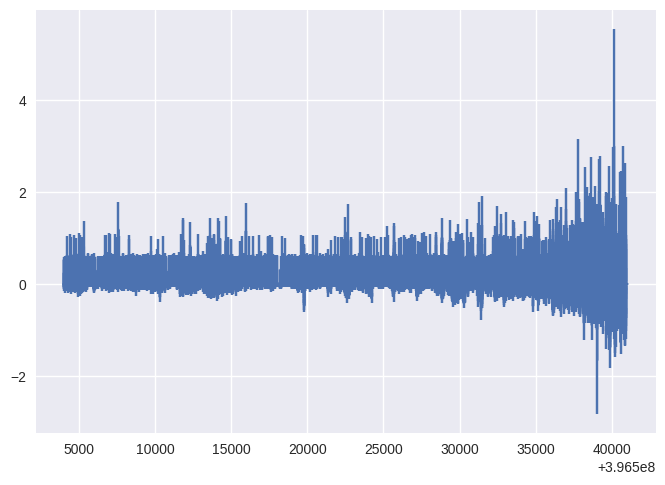

In [74]:
plt.errorbar(x=df.TIME, y=df.RATE, yerr=df.ERROR)

In [ ]:
def lightcurve_binner(bins, mjd_array, magnitude_array, err_magnitude_array):
    binned_mjd = []
    binned_magnitude = []
    binned_err_magnitude = []
    
    bin_indices = np.digitize(mjd_array, bins)
    
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.any(mask):
            weights = 1 / err_magnitude_array[mask]**2

            mean_mjd = np.mean(mjd_array[mask])
            weighted_magnitude = np.average(magnitude_array[mask], weights=weights)
            combined_err_magnitude = np.sqrt(1 / weights.sum())

            binned_mjd.append(mean_mjd)
            binned_magnitude.append(weighted_magnitude)
            binned_err_magnitude.append(combined_err_magnitude)
    
    binned_mjd = np.array(binned_mjd)
    binned_magnitude = np.array(binned_magnitude)
    binned_err_magnitude = np.array(binned_err_magnitude)
    return np.column_stack((binned_mjd, binned_magnitude, binned_err_magnitude))

def apply_time_binning(interval, count_array, time_array):
    err_magnitude_array = lightcurve[:, 2]
    bins = np.arange(int(mjd_array.min()), np.ceil(mjd_array.max()), interval)

In [75]:
bins = np.arange(df.TIME.min(), df.TIME.max(), 200)
bins.shape

(186,)

In [59]:
df['time_bin'] = pd.cut(df['TIME'], bins)
df

,TIME,RATE,ERROR,FRACEXP,BACKV,BACKE,time_bin
0,3.965040e+08,0.000000,0.000000,0.709005,0.000000,0.000000,NaN
1,3.965040e+08,0.000000,0.000000,0.793205,0.000000,0.000000,"(396503995.101, 396504195.101]"
2,3.965040e+08,-0.034844,0.034844,0.797372,0.034844,0.034844,"(396503995.101, 396504195.101]"
3,3.965040e+08,0.240595,0.312667,0.813357,0.068318,0.048308,"(396503995.101, 396504195.101]"
4,3.965040e+08,0.000000,0.000000,0.842992,0.000000,0.000000,"(396503995.101, 396504195.101]"
...,...,...,...,...,...,...,...
9301,3.965410e+08,0.000000,0.000000,0.817056,0.000000,0.000000,NaN
9302,3.965410e+08,0.000000,0.000000,0.818032,0.000000,0.000000,NaN
9303,3.965410e+08,0.000000,0.000000,0.821829,0.000000,0.000000,NaN
9304,3.965410e+08,0.000000,0.000000,0.824337,0.000000,0.000000,NaN


In [60]:
binned_rates = df.groupby('time_bin')['RATE'].sum()

In [61]:
np.mean((1,2))


np.float64(1.5)

In [62]:
avg_times = []
summed_rates = []

for idx, val in binned_rates.items():
    avg_times.append(np.mean((idx.left, idx.right)))
    summed_rates.append(val)

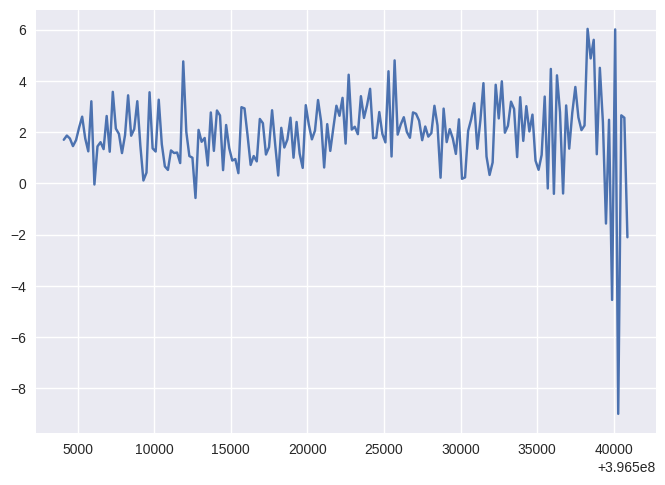

In [63]:
plt.plot(avg_times, summed_rates)

In [ ]:
for 

np.float64(396504045.101)

### Query Epic Courses by Name and Coordinate with `astroquery.esasky`

In [ ]:
def esasky_xmepic_present(row):
    ra, dec = row['meanra'], row['meandec']
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    obs = ESASky.query_object_catalogs(coord, catalogs=['XMM-EPIC'])
    return not len(obs) == 0

all_objects['esasky_xmepic_present'] = all_objects.parallel_apply(esasky_xmepic_present, axis=1)
all_objects

In [14]:
print(ESASky.list_catalogs())

['TYCHO-2', '2RXS', 'PLANCK-PCCS2E-HFI', 'PLANCK-PGCC', 'PLANCK-PCCS2-HFI', 'PLANCK-PCCS2-LFI', 'HERSCHEL-SPSC-250', 'PLANCK-PSZ2', 'HIPPARCOS-2', 'INTEGRAL', 'HERSCHEL-SPSC-500', 'AKARI-IRC-SC', 'HERSCHEL-HPPSC-070', 'HERSCHEL-HPPSC-100', 'HERSCHEL-HPPSC-160', 'HERSCHEL-SPSC-350', 'XMM-SLEW', 'GAIA-DR3', 'XMM-EPIC', 'TWOMASS', 'ALLWISE', 'OU_BLAZARS', 'EROSITA-EFEDS-MAIN', 'EROSITA-EFEDS-HARD', 'EUCLID-MER', 'XMM-EPIC-STACK', 'CHANDRA-SC21', 'XMM-OM', 'FERMI_3FHL', 'EROSITA-ETACHA-MAIN', 'FERMI_4FGL-DR2', 'HCV', 'SWIFT-2SXPS', 'EROSITA-ETACHA-HARD', 'FERMI_4LAC-DR2', 'HSC', 'ICECUBE', 'PLATO ASPIC1.1', '2WHSP', 'GAIA-FPR', 'EROSITA-ERASS-HARD', 'EROSITA-ERASS-MAIN', 'GLADE+', 'LAMOST_MRS', 'LAMOST_LRS']


In [15]:
print(ESASky.list_maps())

['EUCLID-NISP', 'EUCLID-VIS', 'ALMA', 'ISO-IR', 'HST-OPTICAL', 'HST-UV', 'SPITZER', 'AKARI', 'HST-IR', 'EROSITA', 'INTEGRAL', 'JWST-MID-IR', 'JWST-NEAR-IR', 'SUZAKU', 'HERSCHEL', 'XMM', 'XMM-OM-OPTICAL', 'XMM-OM-UV', 'CHANDRA']


In [ ]:
def esasky_xmepic_present(row):
    ra, dec = row['meanra'], row['meandec']
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    obs = ESASky.query_object_catalogs(coord, catalogs=['XMM-EPIC'])
    return not len(obs) == 0

all_objects['esasky_xmepic_present'] = all_objects.parallel_apply(esasky_xmepic_present, axis=1)
all_objects

In [ ]:
all_objects_epic = all_objects.query("esasky_xmepic_present == True")
all_objects_epic

In [ ]:
i = 50
ra, dec = all_objects_epic['meanra'].iloc[i], all_objects_epic['meandec'].iloc[i]

coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
obs = ESASky.query_object_catalogs(coord, catalogs=['XMM-EPIC'])
obs

In [ ]:
obs[0]

In [ ]:
epic_source, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(target_name='[MML2015] 5BZU J2354-0405')

In [ ]:
len(epic_source)

In [ ]:
epic_source, cat_4xmm, stack_4xmm, slew_source = XMMNewton.get_epic_metadata(target_name='                     XLSS J022249.5-051452     ')

In [ ]:
epic_source

In [ ]:
XMMNewton.get_tables(only_names=True)

In [ ]:
XMMNewton.get_columns('xsa.v_epic_source') 